# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных

**Признаки**

RowNumber — индекс строки в данных\
CustomerId — уникальный идентификатор клиента\
Surname — фамилия\
CreditScore — кредитный рейтинг\
Geography — страна проживания\
Gender — пол\
Age — возраст\
Tenure — сколько лет человек является клиентом банка\
Balance — баланс на счёте\
NumOfProducts — количество продуктов банка, используемых клиентом\
HasCrCard — наличие кредитной карты\
IsActiveMember — активность клиента\
EstimatedSalary — предполагаемая зарплата\

**Целевой признак**

Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В датафрейме имеются целочисленные, вещественные и строковые значения. В столбце Tenure имеются пропущенные значения.

In [4]:
df.CustomerId.value_counts().count()

10000

In [5]:
# приведём названия столбцов к нижнему регистру для удоства 
df.columns = map(str.lower, df.columns)
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

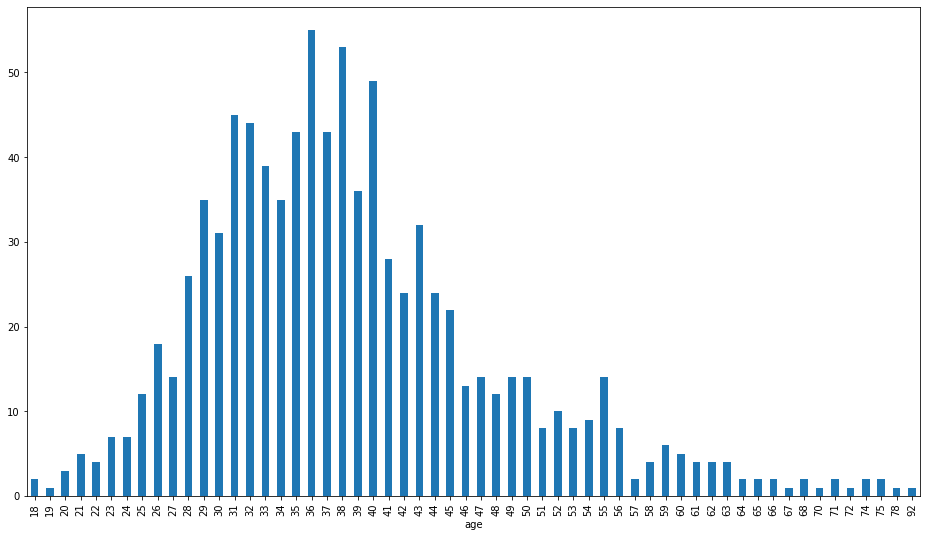

In [6]:
# гистограмма распределения возраста клиентов, для которых в столбце tenure имеются пропущенные значения  
df_age_tenure_nan = df.query('tenure.isna()==True').groupby('age')['age'].count()
df_age_tenure_nan.plot(kind='bar', figsize=(16,9));

Заполним пропущенные значения в столбце tenure средним значением tenure, посчитанным для соответствующей группировки по возрасту клиента. Для этого напишем функцию для группировки и создадим новый столбец age_grouped.

In [7]:
def age_group(age):
    if age <= 20:
        return 1
    if 20 < age <= 25:
        return 2
    if 25 < age <= 30:
        return 3
    if 30 < age <= 40:
        return 4
    if 40 < age <= 50:
        return 5
    if age > 50:
        return 6

df['age_grouped'] = df['age'].apply(age_group)
df.tail()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,age_grouped
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0,4
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0,4
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1,4
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1,5
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0,3


In [8]:
# Замена пропусков столбца tenure средним значением срока группировкой по возрастным категориям
df['tenure'] = df['tenure'].fillna(df.groupby('age_grouped')['tenure'].transform('mean'))

In [9]:
# приведём значения столбца tenure к целочисленному виду тк после работы с пропусками, данные стали вещественными
df['tenure'] = df['tenure'].astype(int)
df.tail()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,age_grouped
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,4
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,4
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,4
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,5
9999,10000,15628319,Walker,792,France,Female,28,5,130142.79,1,1,0,38190.78,0,3


Удалим не нужный далее столбец age_grouped

In [10]:
df = df.drop('age_grouped', axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  int64  
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


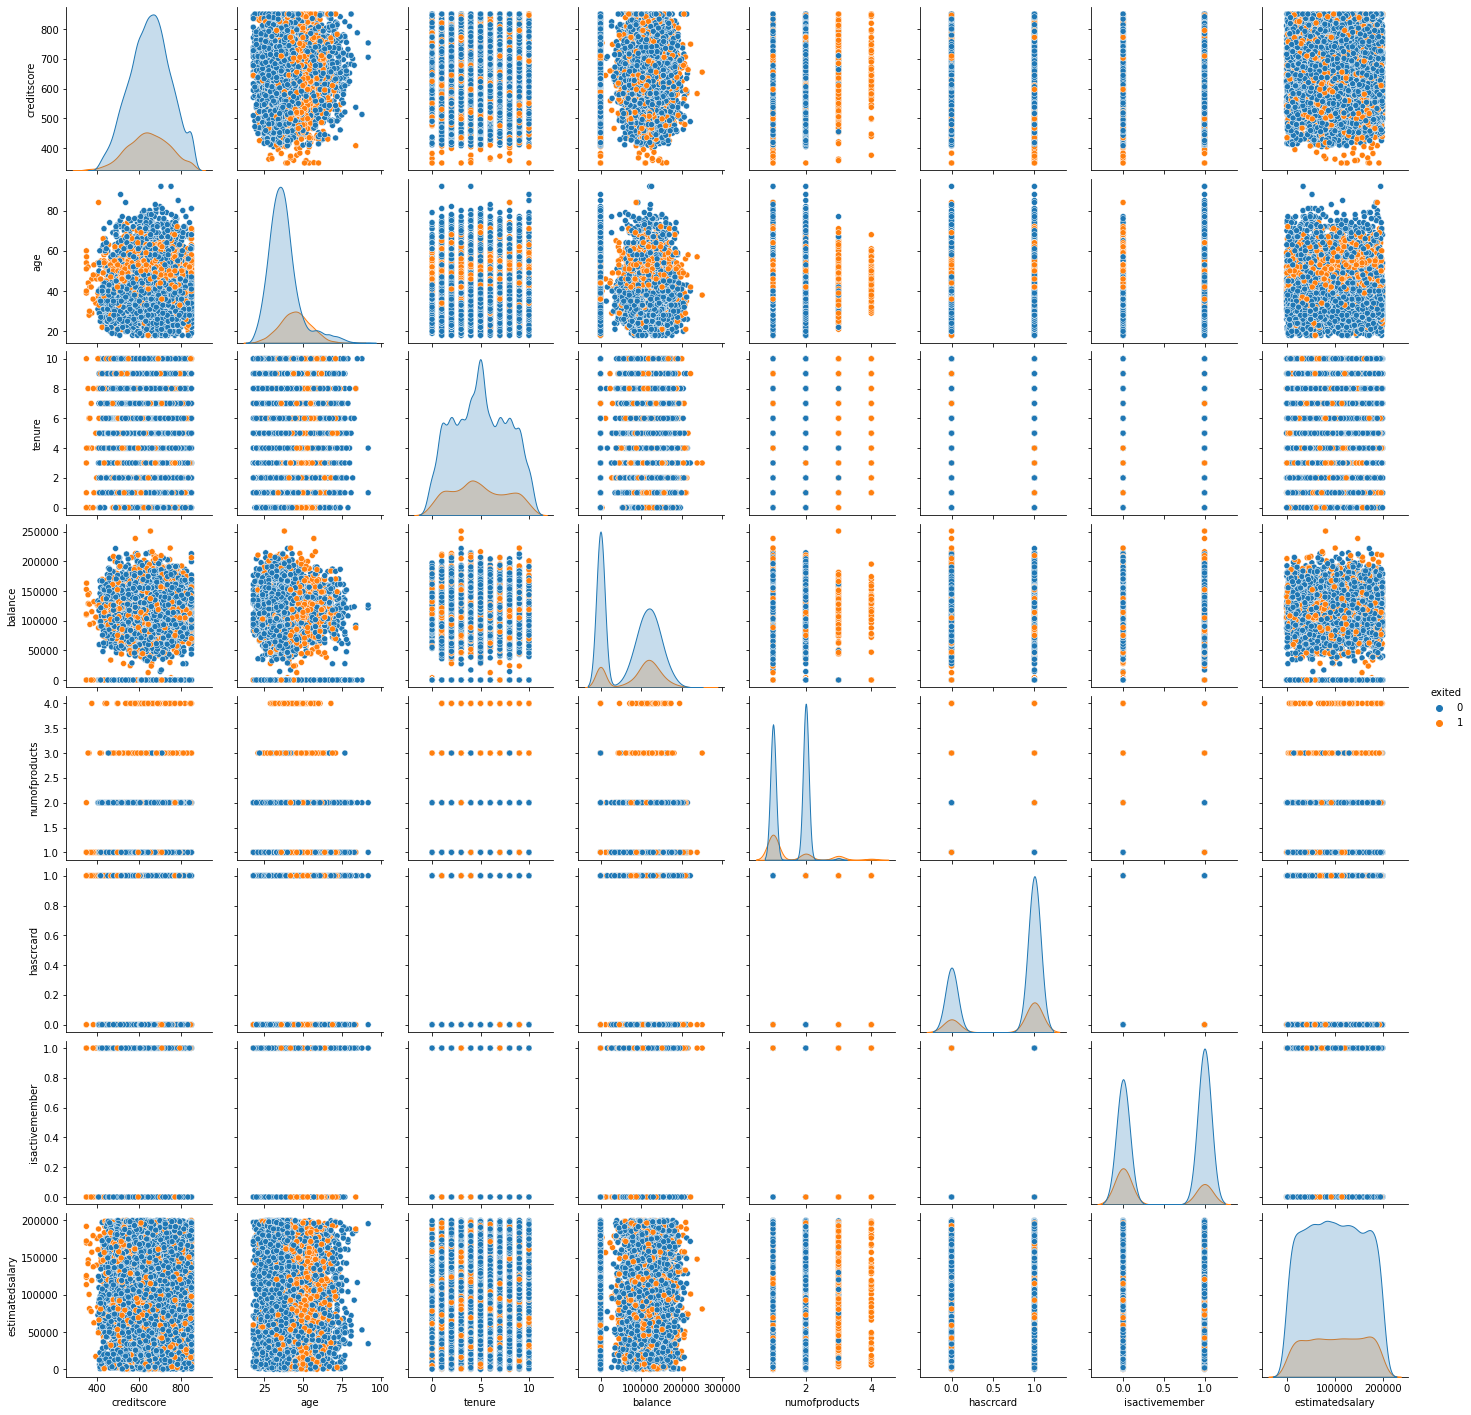

In [12]:
# для визуализации зависимости свойств от целевого признака построим матрицу диаграмм
list = ['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited']
sns.pairplot(df[list], hue='exited');

На представленных графиках не наблюдаются мультиколлинеарности. Данные не являются взаимозависимыми и удаление признаков для улучшения эффективности моделей не трубется.

## Исследование задачи

Для исследования применим модели решающего дерева, случайного леса и логистической регрессии; выберем лучшую модель и оптимизируем под неё гиперпараметры.

In [13]:
# создадим переменные для признаков и целевого признака а также получим из категориальных признаков целочисленные
features = df.drop(['rownumber', 'customerid', 'surname', 'exited'], axis=1)
target = df['exited']
features = pd.get_dummies(features, drop_first=True)
features.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [14]:
# разобьем исходный датасет на 3 выборки - обучающую, валидационную и тестовую в соотношении 60%, 20% и 20% соответственно.
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=.5, random_state=12345)

In [15]:
# проверка
print('Размер тренировочной выборки. Признаки:', features_train.shape, 'Целевой признак:', target_train.shape)
print('Размер валидационной выборки. Признаки:', features_valid.shape, 'Целевой признак:', target_valid.shape)
print('Размер тестовой выборки. Признаки:', features_test.shape, 'Целевой признак:', target_test.shape)

Размер тренировочной выборки. Признаки: (6000, 11) Целевой признак: (6000,)
Размер валидационной выборки. Признаки: (2000, 11) Целевой признак: (2000,)
Размер тестовой выборки. Признаки: (2000, 11) Целевой признак: (2000,)


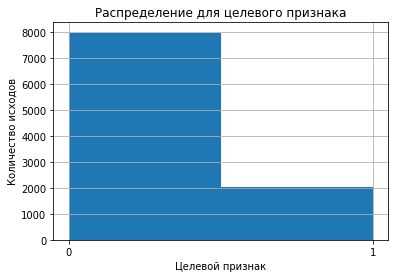

In [16]:
# построим гистограмму распределения значений (0 или 1) для целевого признака exited
target.hist(bins=2)
plt.xticks([0,1])
plt.title('Распределение для целевого признака')
plt.xlabel('Целевой признак')
plt.ylabel('Количество исходов');

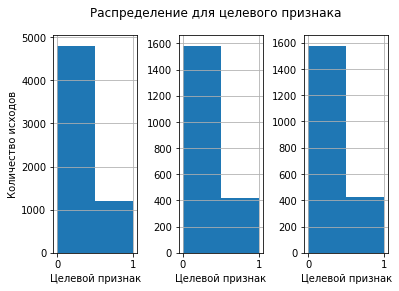

In [17]:
# построим гистограмму распределения значений (0 или 1) для выборок целевого признака exited
plt.suptitle('Распределение для целевого признака')
plt.subplots_adjust(wspace= .5)

plt.subplot(1, 3, 1)
target_train.hist(bins=2)
plt.xticks([0,1])
plt.xlabel('Целевой признак')
plt.ylabel('Количество исходов');

plt.subplot(1, 3, 2)
target_valid.hist(bins=2)
plt.xticks([0,1])
plt.xlabel('Целевой признак')

plt.subplot(1, 3, 3)
target_test.hist(bins=2)
plt.xticks([0,1])
plt.xlabel('Целевой признак');

In [18]:
features.columns

Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'geography_Germany',
       'geography_Spain', 'gender_Male'],
      dtype='object')

In [19]:
pd.options.mode.chained_assignment=None
# масштабирование численных признаков
scaler = StandardScaler()
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'geography_Germany',
       'geography_Spain', 'gender_Male']

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
7479,-0.886751,-0.373192,1.091175,1.232271,-0.891560,0.642466,-1.055187,-0.187705,-0.572475,1.728977,0.907278
3411,0.608663,-0.183385,1.091175,0.600563,-0.891560,-1.556504,-1.055187,-0.333945,-0.572475,-0.578377,-1.102198
6027,2.052152,0.480939,-0.725028,1.027098,0.830152,-1.556504,0.947699,1.503095,1.746802,-0.578377,0.907278
1247,-1.457915,-1.417129,0.364694,-1.233163,0.830152,0.642466,-1.055187,-1.071061,-0.572475,-0.578377,0.907278
3716,0.130961,-1.132419,-1.088269,1.140475,-0.891560,-1.556504,-1.055187,1.524268,1.746802,-0.578377,-1.102198


In [20]:
def plot_roc_curve(clf, features, target):
    probabilities = clf.predict_proba(features)
    probabilities_one = probabilities[:, 1]
    auc_roc = roc_auc_score(target, probabilities_one)
    # метрика AUC-ROC
    print('auc-roc :', auc_roc)
    
    fpr, tpr, thresholds = roc_curve(target, probabilities_one)
    # кривая AUC-ROC
    plt.figure()
    plt.plot(fpr, tpr)
    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

### Решающее дерево

f1: 0.5012224938875306
auc-roc : 0.6835844639757076


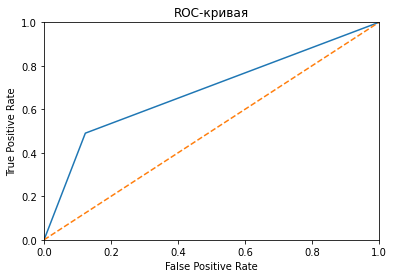

In [21]:
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train, target_train)
predictions_valid = model_tree.predict(features_valid)
print('f1:', f1_score(target_valid, predictions_valid))
plot_roc_curve(model_tree, features_valid, target_valid)

### Случайный лес

f1: 0.5748502994011976
auc-roc : 0.8436242960579244


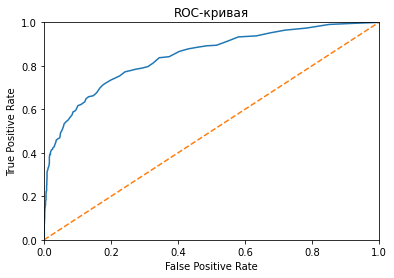

In [22]:
model_forest = RandomForestClassifier(random_state=12345)
model_forest.fit(features_train, target_train)
predictions_valid = model_forest.predict(features_valid)
print('f1:', f1_score(target_valid, predictions_valid))
plot_roc_curve(model_forest, features_valid, target_valid)

### Логистическая регрессия

f1: 0.33389544688026984
auc-roc : 0.7587951173186385


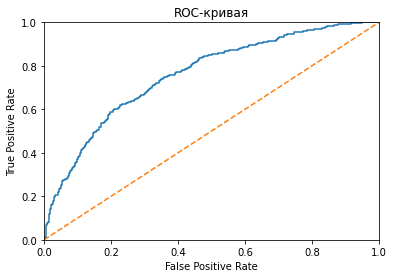

In [23]:
model_log_reg = LogisticRegression(random_state=12345)
model_log_reg.fit(features_train, target_train)
predictions_valid = model_log_reg.predict(features_valid)
print('f1:', f1_score(target_valid, predictions_valid))
plot_roc_curve(model_log_reg, features_valid, target_valid)

Лучшее качество модели даёт случайный лес (для него получены наибольшие показатели метрик f1 и auc-roc), значительно превосходящий по качеству линейную регрессию и более удачный чем дерево решений, хотя даже у него метрика f1 несколько не дотягивает до заданного порога 0.59.

Перейдём к подбору гиперпараметров.

### Подбор гиперпараметров

In [24]:
%%time
parameters = { 'n_estimators': range (60, 131, 10),
              'max_depth': range (10,20, 2) }
clf = RandomForestClassifier(random_state=12345)
grid = GridSearchCV(clf, parameters, scoring='f1')
grid.fit(features_train, target_train)
predictions_valid = grid.predict(features_valid)

display(grid.best_params_)
grid.best_score_

{'max_depth': 16, 'n_estimators': 130}

CPU times: user 1min 48s, sys: 379 ms, total: 1min 48s
Wall time: 1min 49s


0.5740760695457972

In [25]:
# модель с лучшими гиперпараметрами
best_clf = grid.best_estimator_
best_clf

RandomForestClassifier(max_depth=16, n_estimators=130, random_state=12345)

In [26]:
parameters = { 'max_depth': range (1,20, 1) }
clf = DecisionTreeClassifier(random_state=12345)
grid = GridSearchCV(clf, parameters, scoring='f1')
grid.fit(features_train, target_train)
predictions_valid = grid.predict(features_valid)

display(grid.best_params_)
grid.best_score_

{'max_depth': 7}

0.5681046840283853

In [27]:
# # модель с лучшими гиперпараметрами
# best_clf = grid.best_estimator_
# best_clf

**Вывод**\
По итогам выполнения этапа была выявлена лучшая модель с оптимальными гиперпараметрами:
- RandomForestClassifier(max_depth=16, n_estimators=130, random_state=12345).

Метрика f1 для неё практически равна метрике f1 до подбора гиперпараметров и также ниже заданного порога в 0.59. Улучшим качество модели с учетом дисбаланса классов.

## Борьба с дисбалансом

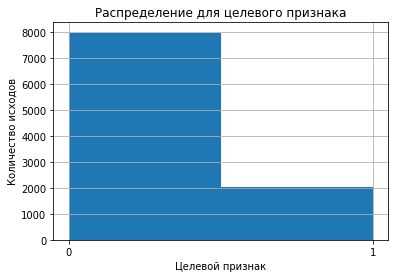

In [28]:
# построим гистограмму распределения значений (0 или 1) для целевого признака exited
target.hist(bins=2)
plt.xticks([0,1])
plt.title('Распределение для целевого признака')
plt.xlabel('Целевой признак')
plt.ylabel('Количество исходов');

Значений целевого признака 0 в 4 раза больше чем значений 1. Чтобы избежать негативного влияния этого фактора на качество обучаемой модели, искусственно сбалансируем целевые признаки.

### Увеличение выборки

In [29]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [30]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

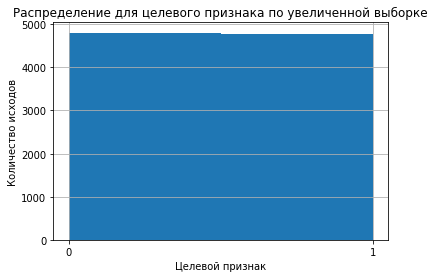

In [31]:
# построим гистограмму распределения значений (0 или 1) для целевого признака exited
target_upsampled.hist(bins=2)
plt.xticks([0,1])
plt.title('Распределение для целевого признака по увеличенной выборке')
plt.xlabel('Целевой признак')
plt.ylabel('Количество исходов');

Дисбаланс устранён. Положительная и отрицательная выборки практически равны.

In [32]:
upsampled_clf = best_clf
upsampled_clf.fit(features_upsampled, target_upsampled)
predicted_valid = upsampled_clf.predict(features_valid)

print("f1:", f1_score(target_valid, predicted_valid))

f1: 0.604890604890605


Увеличение выборки дало положительный эффект. Метрика f1 улучшилась.

### Уменьшение выборки

In [33]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [34]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

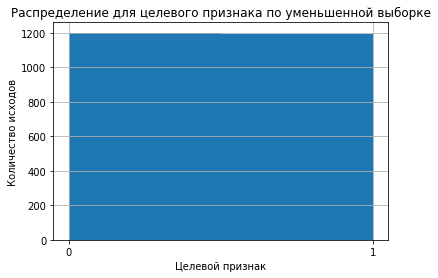

In [35]:
# построим гистограмму распределения значений (0 или 1) для целевого признака exited
target_downsampled.hist(bins=2)
plt.xticks([0,1])
plt.title('Распределение для целевого признака по уменьшенной выборке')
plt.xlabel('Целевой признак')
plt.ylabel('Количество исходов');

In [36]:
downsampled_clf = best_clf
downsampled_clf.fit(features_downsampled, target_downsampled)
predicted_valid = downsampled_clf.predict(features_valid)

print("f1:", f1_score(target_valid, predicted_valid))

f1: 0.5856873822975518


Увеличение выборки даёт больший эффект для повышения эффективности модели.

### Порог классификации

In [37]:
probabilities_valid = best_clf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
max_f1 = 0
threshold = 0
for threshold in np.arange(0.3, 0.7, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    print(f'{threshold=:.02f} : {f1=:.03f}')
    if f1 > max_f1:
        max_f1 = f1
        max_threshold = threshold
print(f'Максимальный f1 равен {max_f1=:.02f} при пороге {max_threshold=:.03f}')

threshold=0.30 : f1=0.480
threshold=0.32 : f1=0.490
threshold=0.34 : f1=0.502
threshold=0.36 : f1=0.510
threshold=0.38 : f1=0.519
threshold=0.40 : f1=0.528
threshold=0.42 : f1=0.540
threshold=0.44 : f1=0.553
threshold=0.46 : f1=0.567
threshold=0.48 : f1=0.578
threshold=0.50 : f1=0.586
threshold=0.52 : f1=0.599
threshold=0.54 : f1=0.604
threshold=0.56 : f1=0.607
threshold=0.58 : f1=0.611
threshold=0.60 : f1=0.618
threshold=0.62 : f1=0.618
threshold=0.64 : f1=0.619
threshold=0.66 : f1=0.609
threshold=0.68 : f1=0.608
Максимальный f1 равен max_f1=0.62 при пороге max_threshold=0.640


**Вывод**
* Увеличение выборки даёт больший эффект для повышения эффективности модели.
* Установление порога классификации позволяет несколько улучшить качество модели. Было достигнуто значение метрики f1=0.62.

Далее на этапе тестирования модели для улучшения её эффективности в качестве борьбы с дисбалансом будем пользоваться увеличением выборки.

## Тестирование модели

In [38]:
# объединение обучающей и валидационной выборок
features_train = features_train.append(features_valid)
target_train = target_train.append(target_valid)
# увеличение выборки
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [39]:
# проверка
display(features_upsampled.shape)
target_upsampled.shape

(12842, 11)

(12842,)

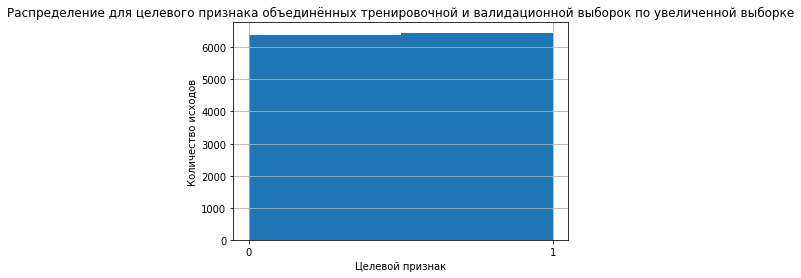

In [40]:
# построим гистограмму распределения значений (0 или 1) для целевого признака exited
target_upsampled.hist(bins=2)
plt.xticks([0,1])
plt.title('Распределение для целевого признака объединённых тренировочной и валидационной выборок по увеличенной выборке')
plt.xlabel('Целевой признак')
plt.ylabel('Количество исходов');

f1: 0.5992414664981037
auc-roc : 0.8547201122519192


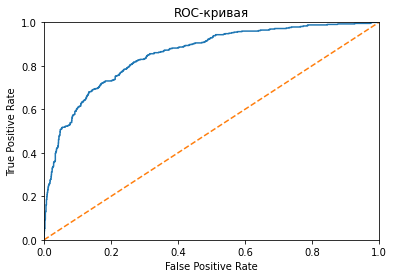

In [41]:
# проверка оптимальной модели на тестовом наборе данных
best_clf.fit(features_upsampled, target_upsampled)
predictions_test = best_clf.predict(features_test)
print("f1:", f'{f1_score(target_test, predictions_test)}')
plot_roc_curve(best_clf, features_test, target_test)

На тестовой выборке показывает значение метрики f1 около 0.599, что сопоставимо с полученным на этапе валидации результатом, хотя он и несколько ниже.

Проверка модели на адекватность. Сравним предсказания нашей модели с фиктивной моделью DummyClassifier.

In [42]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
dummy_predicted = dummy_clf.predict(features_test)
print("f1:", f'{f1_score(target_test, dummy_predicted)}')

f1: 0.0


Созданная нами модель значительно превосходит фиктивную модель.

## Вывод

* Наиболее эффективной является модель случайного леса RandomForestClassifier
* Оптимальные гиперпараметры (max_depth=16, n_estimators=130, random_state=12345)
* Увеличение выборки даёт больший эффект для повышения эффективности модели
* Модель прошла проверку на адекватность
* Достигнут целевой показатель метрики f1. f1=0.599
* Получен показатель метрики AUC-ROC=0.855